In [68]:
from dataset import read_annotations_file, tokenize_sentences
import numpy as np
from model import ImageCaptioningSystem
import pytorch_lightning as pl
from pathlib import Path
from dataset import NWPU_Captions
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from evaluation import eval_validation
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import tqdm

In [5]:
annotations = read_annotations_file("NWPU-Captions/NWPU_images/", "NWPU-Captions/dataset_nwpu.json")
tk = annotations['test']['sentences']
ids = np.array(annotations['test']['img_id'])
order = ids.argsort()
ordered_sentences = np.array(tk)[order]

In [6]:
for i in range(5):
    with open(f'test_references_{i}.txt', 'w') as f:
        for x in ordered_sentences[:,i]:
            x = x.encode('ascii', 'ignore').decode('ascii')
            f.write(x)
            f.write('\n')

In [7]:
data_path = "NWPU-Captions/"
images_path = Path(data_path, "NWPU_images")
annotations_path = Path(data_path, "dataset_nwpu.json")

test_set = NWPU_Captions(
    root=images_path,
    annotations_file=annotations_path,
    split="test",
    transform=ToTensor(),
)

test_loader = DataLoader(
    test_set, batch_size=12, shuffle=False, num_workers=4
)

/home/fe/hufe/miniconda3/envs/remote-sensing/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [9]:
# trainer = pl.Trainer(accelerator="cuda",)
model = ImageCaptioningSystem.load_from_checkpoint("test/full.ckpt", lr=0.001, device_type='cpu', sampling_method='cluster')
# results = trainer.predict(model, test_loader)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v1.9.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file test/full.ckpt`


In [ ]:
confidences = []

with tqdm.tqdm(total=len(test_loader)) as pbar:
    for batch in test_loader:
        pixel_values, sentences_token, img_ids, sentences_ids = batch
        print(img_ids)
        pixel_values = pixel_values.squeeze(dim=1)
        bs = pixel_values.shape[0]
        label = sentences_token[:, 0, :].long().contiguous()

        with torch.no_grad():
            out = model.model(
                    pixel_values=pixel_values, labels=label, output_hidden_states=True
                )

        logits = out.logits
        logits_softmax = torch.nn.functional.softmax(logits, dim=2)
        word_conf, _ = torch.max(logits_softmax, dim=2)

        confidences.append(word_conf.numpy())
        pbar.update(1)


In [60]:
confidences = np.concatenate(confidences)
masked_hits = np.where(confidences != 1, 1, 0)
masked_confidences = np.where(confidences != 1, confidences, 0)
hist = masked_confidences.sum(axis=0) / masked_hits.sum(axis=0)

/tmp/ipykernel_80032/4255783552.py:3: RuntimeWarning: invalid value encountered in divide
  hist = masked_confidences.sum(axis=0) / masked_hits.sum(axis=0)


Text(0, 0.5, 'Confidence')

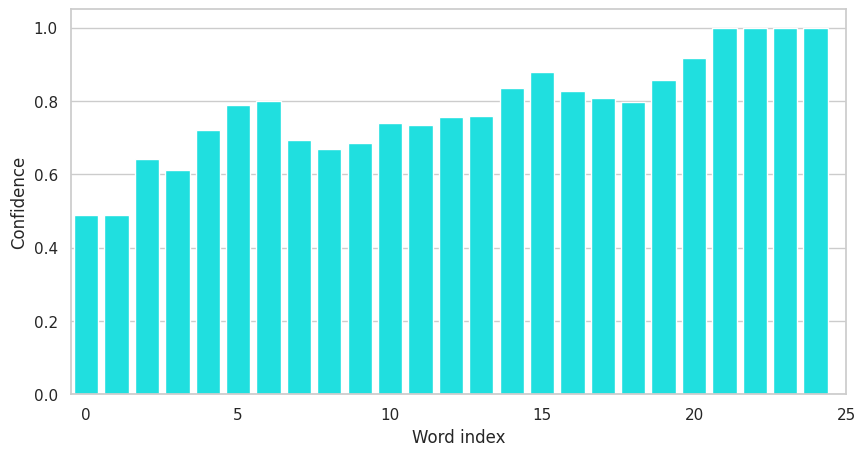

In [78]:
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")

sns.barplot(x=list(range(25)), y=hist[:25], color='cyan')

plt.xticks(ticks=[0, 5, 10, 15, 20, 25], labels=[0, 5, 10, 15, 20, 25])
plt.xlabel('Word index')
plt.ylabel('Confidence')